Let's now work on the model to try and predict the damage level of each building. Let's start by importing the necessary libraries and the dataset containing the one-hot signatures created in the previous notebook.

In [49]:
import torch
import pandas as pd
import numpy as np

from IPython.display import clear_output

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# dataframe = pd.read_csv('signature_dataframe.csv')
dataframe = pd.read_pickle('signature_dataframe.pkl')
dataframe.head()

,x,y
0,"[-0.8674214516922528, 0.5968959280707078, 1, 0...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[-0.7894931324262333, 1.6023856802166563, 0, 1...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[-0.664418864464821, 0.4405339408980041, 1, 0,...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[-0.21363849853229364, 0.19104651928789274, 0,...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[-0.21115149773491346, 0.1691897795630536, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


0     54693
4      4025
9      1549
1      1238
2       954
6       776
7       698
8       550
3       543
10      285
11       44
14       26
5        19
23       18
19       16
16       16
18       15
13       11
17        8
15        8
21        8
12        8
24        7
20        4
22        3
25        1
Name: y, dtype: int64

In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FullyConnectedNN(nn.Module):
    def __init__(self, input_len, output_len, hidden_dim, depth):
        super(FullyConnectedNN, self).__init__()
        self.input_len = input_len
        self.output_len = output_len
        self.depth = depth
        self.hidden_dim = hidden_dim
        self.fc_layers = nn.Sequential()
        
        
        for i in range(depth):
            in_features = self.input_len if i == 0 else self.hidden_dim
            self.fc_layers.add_module(f"fc{i}", nn.Linear(in_features, self.hidden_dim))
            self.fc_layers.add_module(f"relu{i}", nn.ReLU())
        
        self.classifier = nn.Sequential(nn.Linear(self.hidden_dim, self.output_len), nn.Softmax(dim=1))
        self.to(DEVICE)
        # print number of parameters
        print(f"Number of parameters: {sum(p.numel() for p in self.parameters() if p.requires_grad)}")
        
    def forward(self, x):
        x = self.fc_layers(x.view(-1, self.input_len))
        x = self.classifier(x)
        return x


In [73]:
dataframe['y'].iloc[[0,1]]

0    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: y, dtype: object

In [74]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        # Get the label for the current sample
        label = torch.Tensor(self.dataframe['y'].iloc[idx]).to(DEVICE)
        
        # Get the input for the current sample
        input = torch.Tensor(self.dataframe['x'].iloc[idx]).to(DEVICE)
        
        return input, label
    def train_test_split(self, train_size=0.8):
        train_size = int(train_size * len(self))
        test_size = len(self) - train_size
        return torch.utils.data.random_split(self, [train_size, test_size])





In [88]:
dataset = CustomDataset(dataframe)
train_dataset, test_dataset = dataset.train_test_split()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=3200, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=3200, shuffle=True)

In [89]:
# Get weights for each class for loss function

N_CLASSES = len(dataset[0][1])
# get support of each class in dataframe
scalar_df = dataframe['y'].apply(lambda x: np.argmax(x))
weights = scalar_df.value_counts()
# sort weights by key
weights = weights.sort_index()
weights = weights.to_numpy()
weights = torch.Tensor(weights).to(DEVICE)

ALPHA = torch.ones(N_CLASSES).to(DEVICE)/weights
ALPHA

tensor([1.8284e-05, 8.0775e-04, 1.0482e-03, 1.8416e-03, 2.4845e-04, 5.2632e-02,
        1.2887e-03, 1.4327e-03, 1.8182e-03, 6.4558e-04, 3.5088e-03, 2.2727e-02,
        1.2500e-01, 9.0909e-02, 3.8462e-02, 1.2500e-01, 6.2500e-02, 1.2500e-01,
        6.6667e-02, 6.2500e-02, 2.5000e-01, 1.2500e-01, 3.3333e-01, 5.5556e-02,
        1.4286e-01, 1.0000e+00], device='cuda:0')

In [90]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=0.05, logits=True, reduction='elementwise_mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
            
        
        
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'elementwise_mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else: 
            return F_loss
        
        
# This needs fixing, alpha should be a list of length len(targets) ########################################
class FocalLossWithClassBalancing(nn.Module):
    def __init__(self, alpha=ALPHA, gamma=2, reduction='elementwise_mean'): # <----------------------------- alpha should be a list of length len(targets)
        super(FocalLossWithClassBalancing, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        if alpha is None:
            self.alpha = torch.ones(N_CLASSES, dtype=torch.float32).to(DEVICE)    # <--------------------------------------- 25 is the number of classes
        else:
            self.alpha = torch.tensor(alpha, dtype=torch.float32).to(DEVICE)
            
    def forward(self, inputs, targets, alpha=None):
        if alpha != None:
            self.alpha = torch.tensor(alpha, dtype=torch.float32).to(DEVICE)        
        
        BCE_loss = torch.clamp(targets * inputs, 0.000001, 1)

        F_loss = -(self.alpha.repeat(targets.shape[0], 1) * (1-BCE_loss)**self.gamma * BCE_loss.log())
        if self.reduction == 'elementwise_mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

In [91]:
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm



from sklearn.metrics import classification_report

def train(model, train_dataloader, test_dataloader, loss_fn, optimizer, num_epochs, log_interval=10):
    model.to(DEVICE)
    train_losses = []
    test_losses = []
    test_scores = []

    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0

        model.train()
        for i, data in enumerate(train_dataloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_dataloader)
        train_losses.append(train_loss)

        model.eval()
        with torch.no_grad():
            test_loss = 0
            y_true = []
            y_pred = []
            for data in test_dataloader:
                inputs, labels = data
                
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                test_loss += loss.item()
                
                labels = torch.argmax(labels, dim=1).view(-1, 1)
                predicted = torch.argmax(outputs.data, 1).view(-1, 1)
                y_true.extend(labels.cpu().numpy().tolist())
                y_pred.extend(predicted.cpu().numpy().tolist())

        test_loss /= len(test_dataloader)
        test_losses.append(test_loss)
        test_score = classification_report(y_true, y_pred, zero_division=0, output_dict=False)
        
        test_scores.append(test_score)

        if (epoch + 1) % log_interval == 0:
            # clear output
            clear_output(wait=True)
            
            fig, ax = plt.subplots()
            ax.plot(train_losses, label='Training Loss')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Loss')
            ax.legend()

            fig, ax = plt.subplots()
            ax.plot(test_losses, label='Testing Loss')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Loss')
            ax.legend()

            plt.show()
        
        print(f"Epoch {epoch + 1}/{num_epochs}: Training Loss: {train_loss:.4f} Test Loss: {test_loss:.4f} Test Score:\n {test_score} ")



In [92]:
model = FullyConnectedNN(input_len=len(dataset[0][0]), output_len=len(dataset[0][1]), hidden_dim=200, depth=8)

Number of parameters: 302426


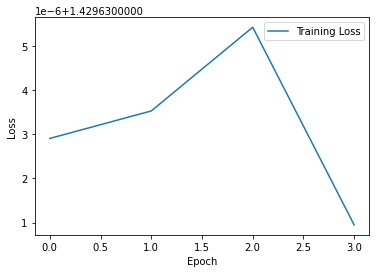

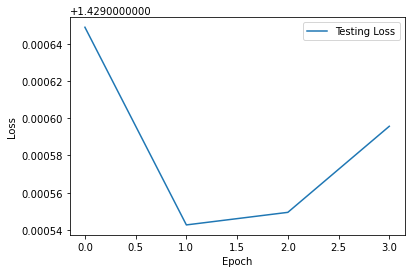

  1%|          | 4/500 [01:11<2:28:28, 17.96s/it]

Epoch 4/500: Training Loss: 1.4296 Test Loss: 1.4296 Test Score:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     10881
           1       0.00      0.00      0.00       239
           2       0.00      0.00      0.00       188
           3       0.00      0.00      0.00       105
           4       0.00      0.00      0.00       811
           5       0.00      1.00      0.00         2
           6       0.00      0.00      0.00       176
           7       0.00      0.00      0.00       156
           8       0.00      0.00      0.00       112
           9       0.00      0.00      0.00       330
          10       0.00      0.00      0.00        58
          11       0.00      0.00      0.00         7
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         4
          17   

  1%|          | 5/500 [01:31<2:35:50, 18.89s/it]

Epoch 5/500: Training Loss: 1.4296 Test Loss: 1.4296 Test Score:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     10881
           1       0.00      0.00      0.00       239
           2       0.00      0.00      0.00       188
           3       0.00      0.00      0.00       105
           4       0.00      0.00      0.00       811
           5       0.00      1.00      0.00         2
           6       0.00      0.00      0.00       176
           7       0.00      0.00      0.00       156
           8       0.00      0.00      0.00       112
           9       0.00      0.00      0.00       330
          10       0.00      0.00      0.00        58
          11       0.00      0.00      0.00         7
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         4
          17   

In [93]:
train(model, train_loader, test_loader, FocalLossWithClassBalancing(), optim.Adam(model.parameters(), lr=0.001), num_epochs=500, log_interval=2)

In [25]:
supports

[['', '', 'precision'],
 ['', 'recall', '', 'f1-score'],
 ['', '', '0'],
 ['', '0.84'],
 ['', '', '10957\n'],
 ['', '', '1'],
 ['', '0.00'],
 ['', '243\n'],
 ['', '', '2'],
 ['', '0.00'],
 ['', '217\n'],
 ['', '', '3'],
 ['', '0.00'],
 ['', '107\n'],
 ['', '', '4'],
 ['', '0.00'],
 ['', '790\n'],
 ['', '', '5'],
 ['', '0.00'],
 ['', '', '6'],
 ['', '0.00'],
 ['', '160\n'],
 ['', '', '7'],
 ['', '0.00'],
 ['', '145\n'],
 ['', '', '8'],
 ['', '0.00'],
 ['', '110\n'],
 ['', '', '9'],
 ['', '0.00'],
 ['', '296\n'],
 ['', '10'],
 ['', '0.00'],
 ['', '', '40\n'],
 ['', '11'],
 ['', '0.00'],
 ['', '12'],
 ['', '0.00'],
 ['', '13'],
 ['', '0.00'],
 ['', '14'],
 ['', '0.00'],
 ['', '15'],
 ['', '0.00'],
 ['', '16'],
 ['', '0.00'],
 ['', '17'],
 ['', '0.00'],
 ['', '18'],
 ['', '0.00'],
 ['', '19'],
 ['', '0.00'],
 ['', '20'],
 ['', '0.00'],
 ['', '21'],
 ['', '0.00'],
 ['', '22'],
 ['', '0.00'],
 ['', '23'],
 ['', '0.00'],
 ['', '24'],
 ['', '0.00'],
 ['', 'accuracy'],
 ['', '', '13105\n'],
 ['

In [78]:
import pickle
# save model
pickle.dump(model, open('model.pkl', 'wb'))